# SLEAP Distance Calculation

Brief 1-2 sentence description of notebook.

In [1]:
import os
import glob
import git
import sys


In [2]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
# import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import h5py
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter


In [3]:
git_repo = git.Repo(".", search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

In [4]:
git_root

'/nancy/user/riwata/projects/reward_comp_ext'

In [5]:
sys.path.insert(0, os.path.join(git_root, 'src'))

In [6]:
import utilities.helper
import sleap.process_pose

In [7]:
# sns.set('notebook', 'ticks', font_scale=1.2)
mpl.rcParams['figure.figsize'] = [15,6]

# Functions

In [8]:
def compute_velocity(node_loc, window_size=25, polynomial_order=3):
    """
    Calculate the velocity of tracked nodes from pose data.
    
    The function utilizes the Savitzky-Golay filter to smooth the data and compute the velocity.
    
    Parameters:
    ----------
    node_loc : numpy.ndarray
        The location of nodes, represented as an array of shape [frames, 2]. 
        Each row represents x and y coordinates for a particular frame.
        
    window_size : int, optional
        The size of the window used for the Savitzky-Golay filter. 
        Represents the number of consecutive data points used when smoothing the data.
        Default is 25.
        
    polynomial_order : int, optional
        The order of the polynomial fit to the data within the Savitzky-Golay filter window.
        Default is 3.

    Returns:
    -------
    numpy.ndarray
        The velocity for each frame, calculated from the smoothed x and y coordinates.
    
    """
    node_loc_vel = np.zeros_like(node_loc)
    
    # For each coordinate (x and y), smooth the data and calculate the derivative (velocity)
    for c in range(node_loc.shape[-1]):
        node_loc_vel[:, c] = savgol_filter(node_loc[:, c], window_size, polynomial_order, deriv=1)
    
    # Calculate the magnitude of the velocity vectors for each frame
    node_vel = np.linalg.norm(node_loc_vel, axis=1)

    return node_vel

In [9]:
def rolling_average(arr, window_size):
    """
    Computes the rolling average using a specified window size.
    
    Parameters:
        arr (numpy.array): The input array to compute the rolling average for.
        window_size (int): The size of the rolling window.

    Returns:
        numpy.array: The rolling average of the input array.
    """
    if window_size < 1:
       raise ValueError("Window size must be at least 1.")
    
    # Create a uniform window of given window size
    window = np.ones(window_size) / window_size

    # Use numpy's convolve function to compute the rolling average
    return np.convolve(arr, window, mode='valid')



In [10]:
def chunked_average(arr, chunk_size):
    """
    Computes the average for non-overlapping chunks of the input array.
    
    Parameters:
        arr (numpy.array): The input array.
        chunk_size (int): The size of each chunk.

    Returns:
        numpy.array: The averages of the non-overlapping chunks.
    """

    # Number of chunks
    num_chunks = len(arr) // chunk_size
    
    # Reshape the array into a 2D array of shape (num_chunks, chunk_size)
    reshaped_arr = arr[:num_chunks * chunk_size].reshape(num_chunks, chunk_size)
    
    # Compute the mean along the second axis (i.e., for each chunk)
    return reshaped_arr.mean(axis=1)

In [11]:
def sliding_window_average(arr, window_size, step=1):
    """
    Apply a sliding window to a 1D numpy array, returning the average of windows of a specified size.

    :param arr: Input 1D numpy array.
    :param window_size: Size of the window.
    :param step: The step size or number of elements to slide the window by. Default is 1.
    :return: A 1D numpy array where each element is the average of a window from the input.
    """
    # Number of windows
    num_windows = ((arr.size - window_size) // step) + 1
    
    # Output array for averages
    averages = np.zeros(num_windows)
    
    for i in range(num_windows):
        # Calculate the start and end index for the window
        start = i * step
        end = start + window_size
        # Calculate the average of the window
        averages[i] = np.mean(arr[start:end])

    return averages

In [12]:
def calculate_all_window_indices(original_index, window_size, step, array_length):
    """
    Calculate all the start and stop indices for sliding windows based on an original start index.

    :param original_index: The original index from which the first window should start.
    :param window_size: The size of each sliding window.
    :param step: The step size or number of elements to slide the window by.
    :param array_length: The total number of elements in the array.
    :return: A list of tuples, each containing the start and stop indices for a sliding window.
    """

    # Initialize the list to hold the start and stop indices for all windows
    windows = []

    # Initialize the current start index with the original index
    current_start_index = original_index

    # Loop through the array until the end is reached
    while current_start_index + window_size <= original_index + array_length:
        # Calculate the stop index based on the window size
        stop_index = current_start_index + window_size

        # Add the start and stop indices to the list
        windows.append((current_start_index, stop_index))

        # Update the current start index by adding the step size
        current_start_index += step

    return windows

## Inputs & Data

Explanation of each input and where it comes from.

In [13]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
THORAX_INDEX = 1

# LFP_SPECTRAL_DF = pd.read_pickle("./proc/rce_pilot_2_03_spectral_bands.pkl")
LFP_SPECTRAL_DF = pd.read_pickle("../2024_11_14_add_spike_times/proc/rce_pilot_3_alone_comp_02_lfp_traces_and_spikes.pkl")
LFP_SPECTRAL_DF["video_name"] = LFP_SPECTRAL_DF["video_name"].apply(lambda x: x.strip(".videoTimeStamps.cameraHWSync"))

# SLEAP_DIR = os.path.join(git_root, "proc/sleap") 
SLEAP_DIR = "/scratch/back_up/reward_competition_extention/final_proc/id_corrected/rce3"
# SLEAP_DIR = "/blue/npadillacoreano/ryoi360/projects/reward_comp/final_proc/id_corrected"

OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs
MED_PC_WIDTH = 29.5
MED_PC_HEIGHT = 24
FRAME_RATE = 22
WINDOW_SIZE = 25
DISTANCE_THRESHOLD = 2

In [14]:
START_STOP_FRAME_DF = pd.read_excel("../../data/rce_pilot_3_alone_comp_per_subject_start_stop_video_frame.xlsx")


## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

In [15]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
OUTPUT_DIR = r"./proc/" # where data is saved should always be shown in the inputs
os.makedirs(OUTPUT_DIR, exist_ok=True)
OUTPUT_PREFIX = "rce_pilot_3_alone_comp"

In [16]:
FULL_LFP_TRACES_PKL = "{}_04_lfp_spike_sleap.pkl".format(OUTPUT_PREFIX)

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

# Getting the videos where the subject is in the recording

### Looking at when each subject was in each video

In [17]:
# START_STOP_FRAME_DF = pd.read_excel("./data/rce_per_subject_start_stop_video_frame.xlsx")
START_STOP_FRAME_DF = START_STOP_FRAME_DF.dropna(subset=["file_path"])

- Getting the name of the SLEAP and video files where each subject was in

In [18]:
START_STOP_FRAME_DF["sleap_name"] = START_STOP_FRAME_DF["file_path"].apply(lambda x: os.path.basename(x))
START_STOP_FRAME_DF["video_name"] = START_STOP_FRAME_DF["file_path"].apply(lambda x: ".".join(os.path.basename(x).split(".")[:2]))
START_STOP_FRAME_DF["start_frame"] = START_STOP_FRAME_DF["start_frame"].astype(int)
START_STOP_FRAME_DF["stop_frame"] = START_STOP_FRAME_DF["stop_frame"].astype(int)

In [19]:
START_STOP_FRAME_DF = START_STOP_FRAME_DF.drop(columns=["file_path", "notes"], errors="ignore")

In [20]:
START_STOP_FRAME_DF["video_name"].unique()

array(['20240320_171038_alone_comp_subj_4-2_and_4-3.1',
       '20240320_142408_alone_comp_subj_3-1_and_3-3.1',
       '20240322_120625_alone_comp_subj_3-3_and_3-4.1',
       '20240322_160946_alone_comp_subj_4-3_and_4-4.1',
       '20240323_122227_alone_comp_subj_5-2_and_5-3.1',
       '20240323_144517_alone_comp_subj_3-1_and_3-4.1',
       '20240323_165815_alone_comp_subj_4-2_and_4-4.1'], dtype=object)

In [21]:
START_STOP_FRAME_DF.head()

,start_frame,stop_frame,tracked_subject,in_video_subjects,box_number,sleap_name,video_name
0,31500,64225,4.2_4.3,4.2_4.3,1,20240320_171038_alone_comp_subj_4-2_and_4-3.1....,20240320_171038_alone_comp_subj_4-2_and_4-3.1
1,31500,63504,3.1_3.3,3.1_3.3,1,20240320_142408_alone_comp_subj_3-1_and_3-3.1....,20240320_142408_alone_comp_subj_3-1_and_3-3.1
2,31500,63314,3.3_3.4,3.3_3.4,1,20240322_120625_alone_comp_subj_3-3_and_3-4.1....,20240322_120625_alone_comp_subj_3-3_and_3-4.1
3,31500,63734,4.3_4.4,4.3_4.4,1,20240322_160946_alone_comp_subj_4-3_and_4-4.1....,20240322_160946_alone_comp_subj_4-3_and_4-4.1
4,31500,63485,5.2_5.3,5.2_5.3,1,20240323_122227_alone_comp_subj_5-2_and_5-3.1....,20240323_122227_alone_comp_subj_5-2_and_5-3.1


- Splitting each row into seperate row for each subject in the video

In [22]:
START_STOP_FRAME_DF["tracked_subject"] = START_STOP_FRAME_DF["tracked_subject"].apply(lambda x: str(x).split("_"))
START_STOP_FRAME_DF["current_subject"] = START_STOP_FRAME_DF["tracked_subject"]

In [23]:
START_STOP_FRAME_DF = START_STOP_FRAME_DF.explode("current_subject")

In [24]:
START_STOP_FRAME_DF.head()

,start_frame,stop_frame,tracked_subject,in_video_subjects,box_number,sleap_name,video_name,current_subject
0,31500,64225,"[4.2, 4.3]",4.2_4.3,1,20240320_171038_alone_comp_subj_4-2_and_4-3.1....,20240320_171038_alone_comp_subj_4-2_and_4-3.1,4.2
0,31500,64225,"[4.2, 4.3]",4.2_4.3,1,20240320_171038_alone_comp_subj_4-2_and_4-3.1....,20240320_171038_alone_comp_subj_4-2_and_4-3.1,4.3
1,31500,63504,"[3.1, 3.3]",3.1_3.3,1,20240320_142408_alone_comp_subj_3-1_and_3-3.1....,20240320_142408_alone_comp_subj_3-1_and_3-3.1,3.1
1,31500,63504,"[3.1, 3.3]",3.1_3.3,1,20240320_142408_alone_comp_subj_3-1_and_3-3.1....,20240320_142408_alone_comp_subj_3-1_and_3-3.1,3.3
2,31500,63314,"[3.3, 3.4]",3.3_3.4,1,20240322_120625_alone_comp_subj_3-3_and_3-4.1....,20240322_120625_alone_comp_subj_3-3_and_3-4.1,3.3


In [25]:
START_STOP_FRAME_DF.shape

(14, 8)

# Reading in the h5 files between recordings

In [26]:
START_STOP_FRAME_DF["sleap_glob"] = START_STOP_FRAME_DF["sleap_name"].apply(lambda x: glob.glob(os.path.join(SLEAP_DIR, "**", x)))


In [27]:
for name in START_STOP_FRAME_DF[START_STOP_FRAME_DF["sleap_glob"].apply(lambda x: len(x) == 0)]["sleap_name"]:
    print(name)

In [28]:
START_STOP_FRAME_DF = START_STOP_FRAME_DF[START_STOP_FRAME_DF['sleap_glob'].apply(lambda x: len(x) >= 1)]
START_STOP_FRAME_DF = START_STOP_FRAME_DF.reset_index(drop=True)




In [29]:
START_STOP_FRAME_DF["sleap_path"] = START_STOP_FRAME_DF["sleap_glob"].apply(lambda x: x[0])

In [30]:
START_STOP_FRAME_DF["all_sleap_data"] = START_STOP_FRAME_DF["sleap_path"].apply(lambda x: sleap.process_pose.extract_sleap_data(x))


In [31]:
START_STOP_FRAME_DF["body_parts"] = START_STOP_FRAME_DF["sleap_path"].apply(lambda x: sleap.process_pose.get_node_names_from_sleap(x))

In [32]:
START_STOP_FRAME_DF["body_parts"].iloc[0]

['left_ear', 'right_ear', 'nose', 'tail_base', 'thorax', 'forehead']

In [33]:
START_STOP_FRAME_DF["locations"] = START_STOP_FRAME_DF["all_sleap_data"].apply(lambda x: x["locations"])

In [34]:
START_STOP_FRAME_DF["track_names"] = START_STOP_FRAME_DF["all_sleap_data"].apply(lambda x: x["track_names"])

In [35]:
START_STOP_FRAME_DF["locations"].iloc[0].shape

(64255, 6, 2, 2)

In [36]:
START_STOP_FRAME_DF.head()

,start_frame,stop_frame,tracked_subject,in_video_subjects,box_number,sleap_name,video_name,current_subject,sleap_glob,sleap_path,all_sleap_data,body_parts,locations,track_names
0,31500,64225,"[4.2, 4.3]",4.2_4.3,1,20240320_171038_alone_comp_subj_4-2_and_4-3.1....,20240320_171038_alone_comp_subj_4-2_and_4-3.1,4.2,[/scratch/back_up/reward_competition_extention...,/scratch/back_up/reward_competition_extention/...,{'locations': [[[[ nan 683.03253174] ...,"[left_ear, right_ear, nose, tail_base, thorax,...","[[[[ nan 683.03253174], [ nan ...","[4.2, 4.3]"
1,31500,64225,"[4.2, 4.3]",4.2_4.3,1,20240320_171038_alone_comp_subj_4-2_and_4-3.1....,20240320_171038_alone_comp_subj_4-2_and_4-3.1,4.3,[/scratch/back_up/reward_competition_extention...,/scratch/back_up/reward_competition_extention/...,{'locations': [[[[ nan 683.03253174] ...,"[left_ear, right_ear, nose, tail_base, thorax,...","[[[[ nan 683.03253174], [ nan ...","[4.2, 4.3]"
2,31500,63504,"[3.1, 3.3]",3.1_3.3,1,20240320_142408_alone_comp_subj_3-1_and_3-3.1....,20240320_142408_alone_comp_subj_3-1_and_3-3.1,3.1,[/scratch/back_up/reward_competition_extention...,/scratch/back_up/reward_competition_extention/...,{'locations': [[[[863.85253906 842.878479 ] ...,"[left_ear, right_ear, nose, tail_base, thorax,...","[[[[863.85253906 842.878479 ], [248.02696228 ...","[3.1, 3.3]"
3,31500,63504,"[3.1, 3.3]",3.1_3.3,1,20240320_142408_alone_comp_subj_3-1_and_3-3.1....,20240320_142408_alone_comp_subj_3-1_and_3-3.1,3.3,[/scratch/back_up/reward_competition_extention...,/scratch/back_up/reward_competition_extention/...,{'locations': [[[[863.85253906 842.878479 ] ...,"[left_ear, right_ear, nose, tail_base, thorax,...","[[[[863.85253906 842.878479 ], [248.02696228 ...","[3.1, 3.3]"
4,31500,63314,"[3.3, 3.4]",3.3_3.4,1,20240322_120625_alone_comp_subj_3-3_and_3-4.1....,20240322_120625_alone_comp_subj_3-3_and_3-4.1,3.3,[/scratch/back_up/reward_competition_extention...,/scratch/back_up/reward_competition_extention/...,{'locations': [[[[ nan 480.05395508] ...,"[left_ear, right_ear, nose, tail_base, thorax,...","[[[[ nan 480.05395508], [ nan ...","[3.3, 3.4]"


In [37]:
# Getting the indexes of each subject from the track list
START_STOP_FRAME_DF["subject_to_index"] = START_STOP_FRAME_DF.apply(lambda x: {k: x["track_names"].index(k) for k in x["tracked_subject"] if k in x["track_names"]}, axis=1)

In [38]:
START_STOP_FRAME_DF["subject_to_index"].head()

0    {'4.2': 0, '4.3': 1}
1    {'4.2': 0, '4.3': 1}
2    {'3.1': 0, '3.3': 1}
3    {'3.1': 0, '3.3': 1}
4    {'3.3': 0, '3.4': 1}
Name: subject_to_index, dtype: object

In [39]:
START_STOP_FRAME_DF["subject_to_tracks"] = START_STOP_FRAME_DF.apply(lambda x: {k:v for k, v in x["subject_to_index"].items()}, axis=1)

In [40]:
START_STOP_FRAME_DF["subject_to_tracks"] = START_STOP_FRAME_DF.apply(lambda x: {k: x["locations"][:,:,:,v] for k, v in x["subject_to_index"].items()}, axis=1)

In [41]:
START_STOP_FRAME_DF["subject_to_tracks"].head()

0    {'4.2': [[[nan nan], [nan nan], [nan nan], [na...
1    {'4.2': [[[nan nan], [nan nan], [nan nan], [na...
2    {'3.1': [[[863.85253906 248.02696228], [880.06...
3    {'3.1': [[[863.85253906 248.02696228], [880.06...
4    {'3.3': [[[nan nan], [nan nan], [nan nan], [na...
Name: subject_to_tracks, dtype: object

In [42]:
START_STOP_FRAME_DF["subject_to_tracks"].apply(lambda x: x.keys()).head()

0    (4.2, 4.3)
1    (4.2, 4.3)
2    (3.1, 3.3)
3    (3.1, 3.3)
4    (3.3, 3.4)
Name: subject_to_tracks, dtype: object

In [43]:
START_STOP_FRAME_DF.head()

,start_frame,stop_frame,tracked_subject,in_video_subjects,box_number,sleap_name,video_name,current_subject,sleap_glob,sleap_path,all_sleap_data,body_parts,locations,track_names,subject_to_index,subject_to_tracks
0,31500,64225,"[4.2, 4.3]",4.2_4.3,1,20240320_171038_alone_comp_subj_4-2_and_4-3.1....,20240320_171038_alone_comp_subj_4-2_and_4-3.1,4.2,[/scratch/back_up/reward_competition_extention...,/scratch/back_up/reward_competition_extention/...,{'locations': [[[[ nan 683.03253174] ...,"[left_ear, right_ear, nose, tail_base, thorax,...","[[[[ nan 683.03253174], [ nan ...","[4.2, 4.3]","{'4.2': 0, '4.3': 1}","{'4.2': [[[nan nan], [nan nan], [nan nan], [na..."
1,31500,64225,"[4.2, 4.3]",4.2_4.3,1,20240320_171038_alone_comp_subj_4-2_and_4-3.1....,20240320_171038_alone_comp_subj_4-2_and_4-3.1,4.3,[/scratch/back_up/reward_competition_extention...,/scratch/back_up/reward_competition_extention/...,{'locations': [[[[ nan 683.03253174] ...,"[left_ear, right_ear, nose, tail_base, thorax,...","[[[[ nan 683.03253174], [ nan ...","[4.2, 4.3]","{'4.2': 0, '4.3': 1}","{'4.2': [[[nan nan], [nan nan], [nan nan], [na..."
2,31500,63504,"[3.1, 3.3]",3.1_3.3,1,20240320_142408_alone_comp_subj_3-1_and_3-3.1....,20240320_142408_alone_comp_subj_3-1_and_3-3.1,3.1,[/scratch/back_up/reward_competition_extention...,/scratch/back_up/reward_competition_extention/...,{'locations': [[[[863.85253906 842.878479 ] ...,"[left_ear, right_ear, nose, tail_base, thorax,...","[[[[863.85253906 842.878479 ], [248.02696228 ...","[3.1, 3.3]","{'3.1': 0, '3.3': 1}","{'3.1': [[[863.85253906 248.02696228], [880.06..."
3,31500,63504,"[3.1, 3.3]",3.1_3.3,1,20240320_142408_alone_comp_subj_3-1_and_3-3.1....,20240320_142408_alone_comp_subj_3-1_and_3-3.1,3.3,[/scratch/back_up/reward_competition_extention...,/scratch/back_up/reward_competition_extention/...,{'locations': [[[[863.85253906 842.878479 ] ...,"[left_ear, right_ear, nose, tail_base, thorax,...","[[[[863.85253906 842.878479 ], [248.02696228 ...","[3.1, 3.3]","{'3.1': 0, '3.3': 1}","{'3.1': [[[863.85253906 248.02696228], [880.06..."
4,31500,63314,"[3.3, 3.4]",3.3_3.4,1,20240322_120625_alone_comp_subj_3-3_and_3-4.1....,20240322_120625_alone_comp_subj_3-3_and_3-4.1,3.3,[/scratch/back_up/reward_competition_extention...,/scratch/back_up/reward_competition_extention/...,{'locations': [[[[ nan 480.05395508] ...,"[left_ear, right_ear, nose, tail_base, thorax,...","[[[[ nan 480.05395508], [ nan ...","[3.3, 3.4]","{'3.3': 0, '3.4': 1}","{'3.3': [[[nan nan], [nan nan], [nan nan], [na..."


## Getting the coordinates of the corners

In [44]:
START_STOP_FRAME_DF["sleap_path"].iloc[0]

'/scratch/back_up/reward_competition_extention/final_proc/id_corrected/rce3/20240320_171038_alone_comp_subj_4-2_and_4-3/20240320_171038_alone_comp_subj_4-2_and_4-3.1.fixed.2_subj.round_3.id_corrected.h5'

In [45]:
# Each corner file is the in the same folder and has the same basename of the pose tracking file 
START_STOP_FRAME_DF["corner_path"] = START_STOP_FRAME_DF["sleap_path"].apply(lambda x: x.replace("id_corrected.h5", "corner.h5").replace(".fixed", "").replace(".round_1", "").replace(".1_subj", "").replace(".2_subj", "").replace(".round_3", ""))


In [46]:
START_STOP_FRAME_DF["corner_path"].iloc[0]

'/scratch/back_up/reward_competition_extention/final_proc/id_corrected/rce3/20240320_171038_alone_comp_subj_4-2_and_4-3/20240320_171038_alone_comp_subj_4-2_and_4-3.1.corner.h5'

In [47]:
# Getting the indexes of each corner location
START_STOP_FRAME_DF["corner_parts"] = START_STOP_FRAME_DF["corner_path"].apply(lambda x: sleap.process_pose.get_node_names_from_sleap(x))

In [48]:
START_STOP_FRAME_DF["video_name"]

0     20240320_171038_alone_comp_subj_4-2_and_4-3.1
1     20240320_171038_alone_comp_subj_4-2_and_4-3.1
2     20240320_142408_alone_comp_subj_3-1_and_3-3.1
3     20240320_142408_alone_comp_subj_3-1_and_3-3.1
4     20240322_120625_alone_comp_subj_3-3_and_3-4.1
5     20240322_120625_alone_comp_subj_3-3_and_3-4.1
6     20240322_160946_alone_comp_subj_4-3_and_4-4.1
7     20240322_160946_alone_comp_subj_4-3_and_4-4.1
8     20240323_122227_alone_comp_subj_5-2_and_5-3.1
9     20240323_122227_alone_comp_subj_5-2_and_5-3.1
10    20240323_144517_alone_comp_subj_3-1_and_3-4.1
11    20240323_144517_alone_comp_subj_3-1_and_3-4.1
12    20240323_165815_alone_comp_subj_4-2_and_4-4.1
13    20240323_165815_alone_comp_subj_4-2_and_4-4.1
Name: video_name, dtype: object

In [49]:
START_STOP_FRAME_DF["corner_parts"]

0     [box_top_right, box_bottom_right, box_top_left...
1     [box_top_right, box_bottom_right, box_top_left...
2     [box_top_right, box_bottom_right, box_top_left...
3     [box_top_right, box_bottom_right, box_top_left...
4     [box_top_right, box_bottom_right, box_top_left...
5     [box_top_right, box_bottom_right, box_top_left...
6     [box_top_right, box_bottom_right, box_top_left...
7     [box_top_right, box_bottom_right, box_top_left...
8     [box_top_right, box_bottom_right, box_top_left...
9     [box_top_right, box_bottom_right, box_top_left...
10    [box_top_right, box_bottom_right, box_top_left...
11    [box_top_right, box_bottom_right, box_top_left...
12    [box_top_right, box_bottom_right, box_top_left...
13    [box_top_right, box_bottom_right, box_top_left...
Name: corner_parts, dtype: object

In [50]:
# TODO: Remove this once corner files are fixed
START_STOP_FRAME_DF = START_STOP_FRAME_DF[START_STOP_FRAME_DF["corner_parts"].apply(lambda x: "reward_port" in x)]

In [51]:
# Getting the coordinates of all the corners
START_STOP_FRAME_DF["corner_to_coordinate"] = START_STOP_FRAME_DF["corner_path"].apply(lambda x: sleap.process_pose.get_sleap_tracks_from_h5(x))

In [52]:
# Parsing out each corner and creating a dictionary of name to coordinates
START_STOP_FRAME_DF["corner_to_coordinate"] = START_STOP_FRAME_DF.apply(lambda x: {part: x["corner_to_coordinate"][:,index,:,:] for index, part in enumerate(x["corner_parts"])}, axis=1)

In [53]:
START_STOP_FRAME_DF["corner_to_coordinate"]

0     {'box_top_right': [[[786.93568988], [138.79375...
1     {'box_top_right': [[[786.93568988], [138.79375...
2     {'box_top_right': [[[794.69379489], [140.52399...
3     {'box_top_right': [[[794.69379489], [140.52399...
4     {'box_top_right': [[[794.99204066], [146.36912...
5     {'box_top_right': [[[794.99204066], [146.36912...
6     {'box_top_right': [[[791.77604498], [147.79694...
7     {'box_top_right': [[[791.77604498], [147.79694...
8     {'box_top_right': [[[798.31429824], [143.32778...
9     {'box_top_right': [[[798.31429824], [143.32778...
10    {'box_top_right': [[[797.85866946], [146.93354...
11    {'box_top_right': [[[797.85866946], [146.93354...
12    {'box_top_right': [[[798.1168476], [144.988990...
13    {'box_top_right': [[[798.1168476], [144.988990...
Name: corner_to_coordinate, dtype: object

In [54]:
# Filtering out all the Nans because there's only one labeled frame
START_STOP_FRAME_DF["corner_to_coordinate"] = START_STOP_FRAME_DF.apply(lambda x: {k: v[~np.isnan(v)][:2] for k, v in x["corner_to_coordinate"].items()}, axis=1)

In [55]:
START_STOP_FRAME_DF["corner_to_coordinate"]

0     {'box_top_right': [786.9356898768796, 138.7937...
1     {'box_top_right': [786.9356898768796, 138.7937...
2     {'box_top_right': [794.6937948883963, 140.5239...
3     {'box_top_right': [794.6937948883963, 140.5239...
4     {'box_top_right': [794.9920406619647, 146.3691...
5     {'box_top_right': [794.9920406619647, 146.3691...
6     {'box_top_right': [791.7760449834286, 147.7969...
7     {'box_top_right': [791.7760449834286, 147.7969...
8     {'box_top_right': [798.3142982402522, 143.3277...
9     {'box_top_right': [798.3142982402522, 143.3277...
10    {'box_top_right': [797.8586694592238, 146.9335...
11    {'box_top_right': [797.8586694592238, 146.9335...
12    {'box_top_right': [798.1168475953126, 144.9889...
13    {'box_top_right': [798.1168475953126, 144.9889...
Name: corner_to_coordinate, dtype: object

# Getting the distances between corners

- Getting the average width and height so that we can convert pixels to cm

In [56]:
# Using the x-coordinates for the width
START_STOP_FRAME_DF["bottom_width"] = START_STOP_FRAME_DF["corner_to_coordinate"].apply(lambda x: x["box_bottom_right"][0] - x["box_bottom_left"][0])
START_STOP_FRAME_DF["top_width"] = START_STOP_FRAME_DF["corner_to_coordinate"].apply(lambda x: x["box_top_right"][0] - x["box_top_left"][0])


In [57]:
# Using the y-coordinates for the height
START_STOP_FRAME_DF["right_height"] = START_STOP_FRAME_DF["corner_to_coordinate"].apply(lambda x: x["box_bottom_right"][1] - x["box_top_right"][1])
START_STOP_FRAME_DF["left_height"] = START_STOP_FRAME_DF["corner_to_coordinate"].apply(lambda x: x["box_bottom_left"][1] - x["box_top_left"][1])


In [58]:
# averaging the width and height by adding both sides and then getting the mean
START_STOP_FRAME_DF["average_height"] = START_STOP_FRAME_DF.apply(lambda row: (row["right_height"] + row["left_height"])/2, axis=1)
START_STOP_FRAME_DF["average_width"] = START_STOP_FRAME_DF.apply(lambda row: (row["bottom_width"] + row["top_width"])/2, axis=1)

- Getthing the pixel to cm ratio

In [59]:
START_STOP_FRAME_DF["width_ratio"] = MED_PC_WIDTH / START_STOP_FRAME_DF["average_width"]
START_STOP_FRAME_DF["height_ratio"] = MED_PC_HEIGHT / START_STOP_FRAME_DF["average_height"]

In [60]:
START_STOP_FRAME_DF["height_ratio"]

0     0.061209
1     0.061209
2     0.061215
3     0.061215
4     0.060985
5     0.060985
6     0.060953
7     0.060953
8     0.060977
9     0.060977
10    0.061329
11    0.061329
12    0.060046
13    0.060046
Name: height_ratio, dtype: float64

In [61]:
START_STOP_FRAME_DF["width_ratio"]

0     0.094355
1     0.094355
2     0.093446
3     0.093446
4     0.093614
5     0.093614
6     0.093866
7     0.093866
8     0.092309
9     0.092309
10    0.092618
11    0.092618
12    0.093712
13    0.093712
Name: width_ratio, dtype: float64

## Converting Pixels to cm

In [62]:
START_STOP_FRAME_DF["in_video_subjects"] = START_STOP_FRAME_DF["in_video_subjects"].apply(lambda x: x.split("_"))

In [63]:
START_STOP_FRAME_DF["subject_to_tracks"] = START_STOP_FRAME_DF.apply(lambda x: {k: v for k, v in x["subject_to_tracks"].items() if k in x["in_video_subjects"]}, axis=1)

- Converting the X-dimension

In [64]:
START_STOP_FRAME_DF["subject_to_tracks"].head()

0    {'4.2': [[[nan nan], [nan nan], [nan nan], [na...
1    {'4.2': [[[nan nan], [nan nan], [nan nan], [na...
2    {'3.1': [[[863.85253906 248.02696228], [880.06...
3    {'3.1': [[[863.85253906 248.02696228], [880.06...
4    {'3.3': [[[nan nan], [nan nan], [nan nan], [na...
Name: subject_to_tracks, dtype: object

In [65]:
START_STOP_FRAME_DF["rescaled_locations"] = START_STOP_FRAME_DF.apply(lambda x: {key: sleap.process_pose.fill_missing(sleap.process_pose.rescale_dimension_in_array(value, dimension=0, ratio=x["width_ratio"])) for key, value in x["subject_to_tracks"].items()}, axis=1)

- Converting the Y-dimension

In [66]:
START_STOP_FRAME_DF["rescaled_locations"] = START_STOP_FRAME_DF.apply(lambda x: {key: sleap.process_pose.rescale_dimension_in_array(value, dimension=1, ratio=x["height_ratio"]) for key, value in x["rescaled_locations"].items()}, axis=1)

In [67]:
START_STOP_FRAME_DF["corner_to_coordinate"]

0     {'box_top_right': [786.9356898768796, 138.7937...
1     {'box_top_right': [786.9356898768796, 138.7937...
2     {'box_top_right': [794.6937948883963, 140.5239...
3     {'box_top_right': [794.6937948883963, 140.5239...
4     {'box_top_right': [794.9920406619647, 146.3691...
5     {'box_top_right': [794.9920406619647, 146.3691...
6     {'box_top_right': [791.7760449834286, 147.7969...
7     {'box_top_right': [791.7760449834286, 147.7969...
8     {'box_top_right': [798.3142982402522, 143.3277...
9     {'box_top_right': [798.3142982402522, 143.3277...
10    {'box_top_right': [797.8586694592238, 146.9335...
11    {'box_top_right': [797.8586694592238, 146.9335...
12    {'box_top_right': [798.1168475953126, 144.9889...
13    {'box_top_right': [798.1168475953126, 144.9889...
Name: corner_to_coordinate, dtype: object

In [68]:
START_STOP_FRAME_DF.head()

,start_frame,stop_frame,tracked_subject,in_video_subjects,box_number,sleap_name,video_name,current_subject,sleap_glob,sleap_path,...,corner_to_coordinate,bottom_width,top_width,right_height,left_height,average_height,average_width,width_ratio,height_ratio,rescaled_locations
0,31500,64225,"[4.2, 4.3]","[4.2, 4.3]",1,20240320_171038_alone_comp_subj_4-2_and_4-3.1....,20240320_171038_alone_comp_subj_4-2_and_4-3.1,4.2,[/scratch/back_up/reward_competition_extention...,/scratch/back_up/reward_competition_extention/...,...,"{'box_top_right': [786.9356898768796, 138.7937...",313.180772,312.115659,393.771087,390.423247,392.097167,312.648215,0.094355,0.061209,"{'4.2': [[[64.90703525 33.2852899 ], [47.51540..."
1,31500,64225,"[4.2, 4.3]","[4.2, 4.3]",1,20240320_171038_alone_comp_subj_4-2_and_4-3.1....,20240320_171038_alone_comp_subj_4-2_and_4-3.1,4.3,[/scratch/back_up/reward_competition_extention...,/scratch/back_up/reward_competition_extention/...,...,"{'box_top_right': [786.9356898768796, 138.7937...",313.180772,312.115659,393.771087,390.423247,392.097167,312.648215,0.094355,0.061209,"{'4.2': [[[64.90703525 33.2852899 ], [47.51540..."
2,31500,63504,"[3.1, 3.3]","[3.1, 3.3]",1,20240320_142408_alone_comp_subj_3-1_and_3-3.1....,20240320_142408_alone_comp_subj_3-1_and_3-3.1,3.1,[/scratch/back_up/reward_competition_extention...,/scratch/back_up/reward_competition_extention/...,...,"{'box_top_right': [794.6937948883963, 140.5239...",313.159588,318.222032,392.230308,391.894156,392.062232,315.690810,0.093446,0.061215,"{'3.1': [[[80.72344549 15.18291385], [82.23835..."
3,31500,63504,"[3.1, 3.3]","[3.1, 3.3]",1,20240320_142408_alone_comp_subj_3-1_and_3-3.1....,20240320_142408_alone_comp_subj_3-1_and_3-3.1,3.3,[/scratch/back_up/reward_competition_extention...,/scratch/back_up/reward_competition_extention/...,...,"{'box_top_right': [794.6937948883963, 140.5239...",313.159588,318.222032,392.230308,391.894156,392.062232,315.690810,0.093446,0.061215,"{'3.1': [[[80.72344549 15.18291385], [82.23835..."
4,31500,63314,"[3.3, 3.4]","[3.3, 3.4]",1,20240322_120625_alone_comp_subj_3-3_and_3-4.1....,20240322_120625_alone_comp_subj_3-3_and_3-4.1,3.3,[/scratch/back_up/reward_competition_extention...,/scratch/back_up/reward_competition_extention/...,...,"{'box_top_right': [794.9920406619647, 146.3691...",315.545530,314.702270,395.661099,391.411856,393.536477,315.123900,0.093614,0.060985,"{'3.3': [[[42.67602103 38.8675019 ], [55.40950..."


In [69]:
# Normalize dictionary column
normalized = pd.json_normalize(START_STOP_FRAME_DF["corner_to_coordinate"])

In [70]:
normalized.head()

,box_top_right,box_bottom_right,box_top_left,reward_port,box_bottom_left
0,"[786.9356898768796, 138.79375971024683]","[803.8390342800585, 532.5648468296024]","[474.82003129890455, 155.5329253476304]","[648.7548067996038, 573.1929845564649]","[490.6582624706881, 545.9561721319552]"
1,"[786.9356898768796, 138.79375971024683]","[803.8390342800585, 532.5648468296024]","[474.82003129890455, 155.5329253476304]","[648.7548067996038, 573.1929845564649]","[490.6582624706881, 545.9561721319552]"
2,"[794.6937948883963, 140.52399579213056]","[804.1742506477467, 532.7543035993741]","[476.4717627957939, 154.74047278598346]","[651.6736981833109, 572.3888520918972]","[491.01466249883674, 546.6346292517417]"
3,"[794.6937948883963, 140.52399579213056]","[804.1742506477467, 532.7543035993741]","[476.4717627957939, 154.74047278598346]","[651.6736981833109, 572.3888520918972]","[491.01466249883674, 546.6346292517417]"
4,"[794.9920406619647, 146.36912385006906]","[808.2372355317932, 542.03022271899]","[480.2897707640422, 158.4813490864459]","[647.8268059373486, 573.3043465519602]","[492.6917057902973, 549.8932050538807]"


In [71]:


# Drop the original column and concat the normalized DataFrame
START_STOP_FRAME_DF = pd.concat([START_STOP_FRAME_DF.drop(["corner_to_coordinate"], axis=1), normalized], axis=1)


In [72]:
START_STOP_FRAME_DF.head()

,start_frame,stop_frame,tracked_subject,in_video_subjects,box_number,sleap_name,video_name,current_subject,sleap_glob,sleap_path,...,average_height,average_width,width_ratio,height_ratio,rescaled_locations,box_top_right,box_bottom_right,box_top_left,reward_port,box_bottom_left
0,31500,64225,"[4.2, 4.3]","[4.2, 4.3]",1,20240320_171038_alone_comp_subj_4-2_and_4-3.1....,20240320_171038_alone_comp_subj_4-2_and_4-3.1,4.2,[/scratch/back_up/reward_competition_extention...,/scratch/back_up/reward_competition_extention/...,...,392.097167,312.648215,0.094355,0.061209,"{'4.2': [[[64.90703525 33.2852899 ], [47.51540...","[786.9356898768796, 138.79375971024683]","[803.8390342800585, 532.5648468296024]","[474.82003129890455, 155.5329253476304]","[648.7548067996038, 573.1929845564649]","[490.6582624706881, 545.9561721319552]"
1,31500,64225,"[4.2, 4.3]","[4.2, 4.3]",1,20240320_171038_alone_comp_subj_4-2_and_4-3.1....,20240320_171038_alone_comp_subj_4-2_and_4-3.1,4.3,[/scratch/back_up/reward_competition_extention...,/scratch/back_up/reward_competition_extention/...,...,392.097167,312.648215,0.094355,0.061209,"{'4.2': [[[64.90703525 33.2852899 ], [47.51540...","[786.9356898768796, 138.79375971024683]","[803.8390342800585, 532.5648468296024]","[474.82003129890455, 155.5329253476304]","[648.7548067996038, 573.1929845564649]","[490.6582624706881, 545.9561721319552]"
2,31500,63504,"[3.1, 3.3]","[3.1, 3.3]",1,20240320_142408_alone_comp_subj_3-1_and_3-3.1....,20240320_142408_alone_comp_subj_3-1_and_3-3.1,3.1,[/scratch/back_up/reward_competition_extention...,/scratch/back_up/reward_competition_extention/...,...,392.062232,315.690810,0.093446,0.061215,"{'3.1': [[[80.72344549 15.18291385], [82.23835...","[794.6937948883963, 140.52399579213056]","[804.1742506477467, 532.7543035993741]","[476.4717627957939, 154.74047278598346]","[651.6736981833109, 572.3888520918972]","[491.01466249883674, 546.6346292517417]"
3,31500,63504,"[3.1, 3.3]","[3.1, 3.3]",1,20240320_142408_alone_comp_subj_3-1_and_3-3.1....,20240320_142408_alone_comp_subj_3-1_and_3-3.1,3.3,[/scratch/back_up/reward_competition_extention...,/scratch/back_up/reward_competition_extention/...,...,392.062232,315.690810,0.093446,0.061215,"{'3.1': [[[80.72344549 15.18291385], [82.23835...","[794.6937948883963, 140.52399579213056]","[804.1742506477467, 532.7543035993741]","[476.4717627957939, 154.74047278598346]","[651.6736981833109, 572.3888520918972]","[491.01466249883674, 546.6346292517417]"
4,31500,63314,"[3.3, 3.4]","[3.3, 3.4]",1,20240322_120625_alone_comp_subj_3-3_and_3-4.1....,20240322_120625_alone_comp_subj_3-3_and_3-4.1,3.3,[/scratch/back_up/reward_competition_extention...,/scratch/back_up/reward_competition_extention/...,...,393.536477,315.123900,0.093614,0.060985,"{'3.3': [[[42.67602103 38.8675019 ], [55.40950...","[794.9920406619647, 146.36912385006906]","[808.2372355317932, 542.03022271899]","[480.2897707640422, 158.4813490864459]","[647.8268059373486, 573.3043465519602]","[492.6917057902973, 549.8932050538807]"


In [73]:
START_STOP_FRAME_DF = START_STOP_FRAME_DF.dropna(subset=["reward_port"])

- Converting the corner coordinates into cms

In [74]:
for corner in START_STOP_FRAME_DF["corner_parts"].iloc[0]:
    START_STOP_FRAME_DF[corner] = START_STOP_FRAME_DF.apply(lambda x: [x[corner][0]*x["width_ratio"], x[corner][1]*x["height_ratio"]], axis=1)

## Looking over the tracks

In [75]:
FILE_INDEX = 0

In [76]:
START_STOP_FRAME_DF["sleap_path"].iloc[FILE_INDEX]

'/scratch/back_up/reward_competition_extention/final_proc/id_corrected/rce3/20240320_171038_alone_comp_subj_4-2_and_4-3/20240320_171038_alone_comp_subj_4-2_and_4-3.1.fixed.2_subj.round_3.id_corrected.h5'

In [77]:
START_STOP_FRAME_DF["rescaled_locations"].head()

0    {'4.2': [[[64.90703525 33.2852899 ], [47.51540...
1    {'4.2': [[[64.90703525 33.2852899 ], [47.51540...
2    {'3.1': [[[80.72344549 15.18291385], [82.23835...
3    {'3.1': [[[80.72344549 15.18291385], [82.23835...
4    {'3.3': [[[42.67602103 38.8675019 ], [55.40950...
Name: rescaled_locations, dtype: object

In [78]:
START_STOP_FRAME_DF.columns

Index(['start_frame', 'stop_frame', 'tracked_subject', 'in_video_subjects',
       'box_number', 'sleap_name', 'video_name', 'current_subject',
       'sleap_glob', 'sleap_path', 'all_sleap_data', 'body_parts', 'locations',
       'track_names', 'subject_to_index', 'subject_to_tracks', 'corner_path',
       'corner_parts', 'bottom_width', 'top_width', 'right_height',
       'left_height', 'average_height', 'average_width', 'width_ratio',
       'height_ratio', 'rescaled_locations', 'box_top_right',
       'box_bottom_right', 'box_top_left', 'reward_port', 'box_bottom_left'],
      dtype='object')

In [79]:
with h5py.File(START_STOP_FRAME_DF["sleap_path"].iloc[FILE_INDEX], "r") as f:
    dset_names = list(f.keys())
    current_subject = START_STOP_FRAME_DF["current_subject"].iloc[FILE_INDEX]
    locations = START_STOP_FRAME_DF["rescaled_locations"].iloc[FILE_INDEX][current_subject]
    node_names = [n.decode() for n in f["node_names"][:]]
    
print("===HDF5 datasets===")
print(dset_names)
print()

print("===locations data shape===")
print(locations.shape)
print()

print("===nodes===")
for i, name in enumerate(node_names):
    print(f"{i}: {name}")
print()

===HDF5 datasets===
['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']

===locations data shape===
(64255, 6, 2)

===nodes===
0: left_ear
1: right_ear
2: nose
3: tail_base
4: thorax
5: forehead



In [80]:
thorax_loc = locations[:, THORAX_INDEX, :]

Text(0, 0.5, 'Coordinate Position')

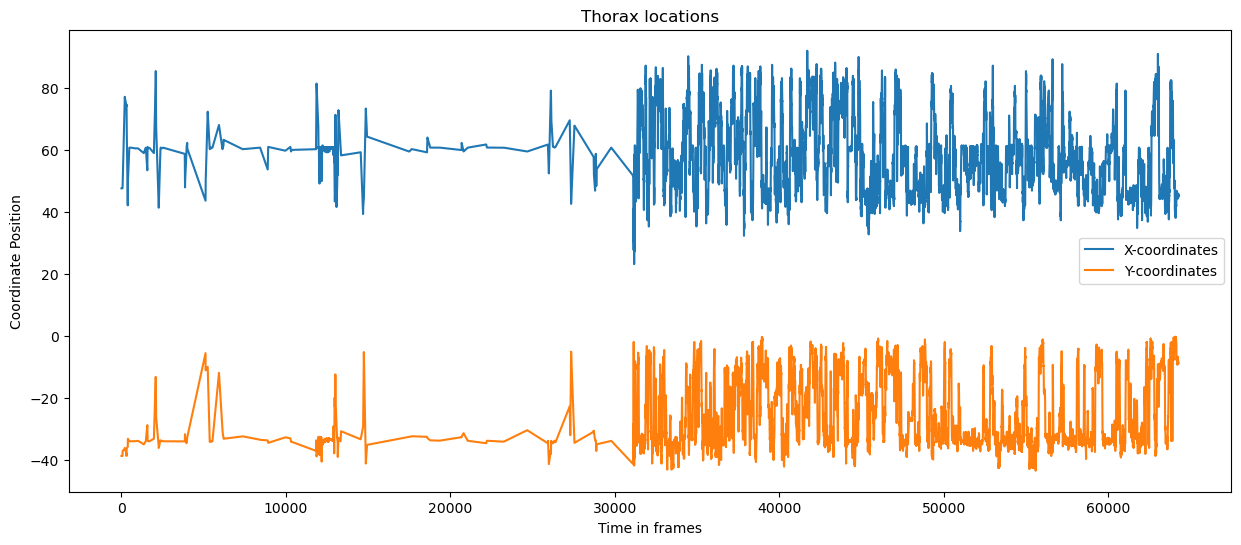

In [81]:
fig, ax = plt.subplots()

plt.plot(thorax_loc[:,0],label='X-coordinates')
# Converting to negative so that we can see both x and y track
plt.plot(-1*thorax_loc[:,1], label='Y-coordinates')

plt.legend(loc="center right")
plt.title('Thorax locations')
plt.xlabel("Time in frames")
plt.ylabel("Coordinate Position")

Text(0, 0.5, 'Y-Coordinates')

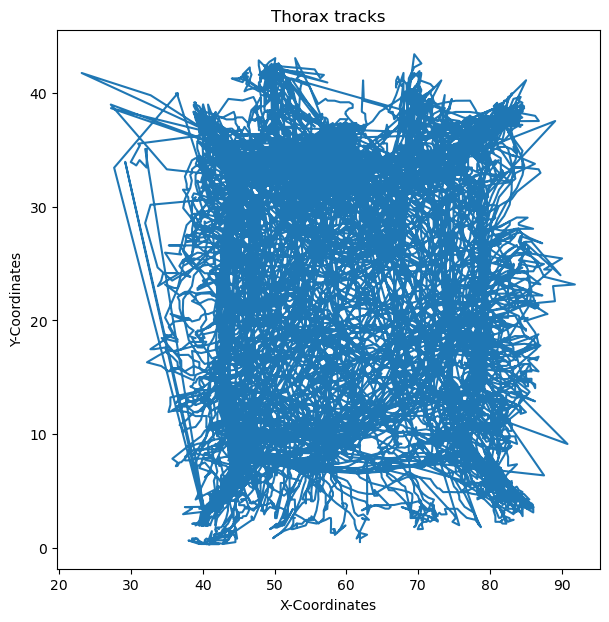

In [82]:
plt.figure(figsize=(7,7))
plt.plot(thorax_loc[:,0],thorax_loc[:,1])


plt.title('Thorax tracks')
plt.xlabel("X-Coordinates")
plt.ylabel("Y-Coordinates")


## Creating an individual column for each pose tracking

In [83]:
START_STOP_FRAME_DF = START_STOP_FRAME_DF.dropna(subset="current_subject")

In [84]:
START_STOP_FRAME_DF.head()

,start_frame,stop_frame,tracked_subject,in_video_subjects,box_number,sleap_name,video_name,current_subject,sleap_glob,sleap_path,...,average_height,average_width,width_ratio,height_ratio,rescaled_locations,box_top_right,box_bottom_right,box_top_left,reward_port,box_bottom_left
0,31500,64225,"[4.2, 4.3]","[4.2, 4.3]",1,20240320_171038_alone_comp_subj_4-2_and_4-3.1....,20240320_171038_alone_comp_subj_4-2_and_4-3.1,4.2,[/scratch/back_up/reward_competition_extention...,/scratch/back_up/reward_competition_extention/...,...,392.097167,312.648215,0.094355,0.061209,"{'4.2': [[[64.90703525 33.2852899 ], [47.51540...","[74.25151247701015, 8.495471311209611]","[75.846431736616, 32.597930822286116]","[44.801761988760454, 9.52006421612736]","[61.213420932957966, 35.084751405625006]","[46.2961822248657, 33.41760470505085]"
1,31500,64225,"[4.2, 4.3]","[4.2, 4.3]",1,20240320_171038_alone_comp_subj_4-2_and_4-3.1....,20240320_171038_alone_comp_subj_4-2_and_4-3.1,4.3,[/scratch/back_up/reward_competition_extention...,/scratch/back_up/reward_competition_extention/...,...,392.097167,312.648215,0.094355,0.061209,"{'4.2': [[[64.90703525 33.2852899 ], [47.51540...","[74.25151247701015, 8.495471311209611]","[75.846431736616, 32.597930822286116]","[44.801761988760454, 9.52006421612736]","[61.213420932957966, 35.084751405625006]","[46.2961822248657, 33.41760470505085]"
2,31500,63504,"[3.1, 3.3]","[3.1, 3.3]",1,20240320_142408_alone_comp_subj_3-1_and_3-3.1....,20240320_142408_alone_comp_subj_3-1_and_3-3.1,3.1,[/scratch/back_up/reward_competition_extention...,/scratch/back_up/reward_competition_extention/...,...,392.062232,315.690810,0.093446,0.061215,"{'3.1': [[[80.72344549 15.18291385], [82.23835...","[74.26084699849272, 8.602144309163993]","[75.1467563627655, 32.612433022962925]","[44.524314778435695, 9.472402701545125]","[60.89621072293514, 35.03865285708705]","[45.88328858282252, 33.462113987746186]"
3,31500,63504,"[3.1, 3.3]","[3.1, 3.3]",1,20240320_142408_alone_comp_subj_3-1_and_3-3.1....,20240320_142408_alone_comp_subj_3-1_and_3-3.1,3.3,[/scratch/back_up/reward_competition_extention...,/scratch/back_up/reward_competition_extention/...,...,392.062232,315.690810,0.093446,0.061215,"{'3.1': [[[80.72344549 15.18291385], [82.23835...","[74.26084699849272, 8.602144309163993]","[75.1467563627655, 32.612433022962925]","[44.524314778435695, 9.472402701545125]","[60.89621072293514, 35.03865285708705]","[45.88328858282252, 33.462113987746186]"
4,31500,63314,"[3.3, 3.4]","[3.3, 3.4]",1,20240322_120625_alone_comp_subj_3-3_and_3-4.1....,20240322_120625_alone_comp_subj_3-3_and_3-4.1,3.3,[/scratch/back_up/reward_competition_extention...,/scratch/back_up/reward_competition_extention/...,...,393.536477,315.123900,0.093614,0.060985,"{'3.3': [[[42.67602103 38.8675019 ], [55.40950...","[74.42236280061786, 8.926387194010582]","[75.66229810506, 33.05595819376228]","[44.96183325239834, 9.665056726197681]","[60.64564060702992, 34.963224775288616]","[46.12282765327953, 33.535485726445984]"


In [85]:
START_STOP_FRAME_DF["agent"] = START_STOP_FRAME_DF.apply(lambda x: list((set(x["tracked_subject"]) - set([x["current_subject"]]))), axis=1)

In [86]:
START_STOP_FRAME_DF[START_STOP_FRAME_DF["agent"].apply(lambda x: len(x) != 1)]

,start_frame,stop_frame,tracked_subject,in_video_subjects,box_number,sleap_name,video_name,current_subject,sleap_glob,sleap_path,...,average_width,width_ratio,height_ratio,rescaled_locations,box_top_right,box_bottom_right,box_top_left,reward_port,box_bottom_left,agent


In [87]:
START_STOP_FRAME_DF["agent"] = START_STOP_FRAME_DF["agent"].apply(lambda x: x[0] if len(x) == 1 else None)

In [88]:
START_STOP_FRAME_DF["subject_locations"] = START_STOP_FRAME_DF.apply(lambda x: x["rescaled_locations"][x["current_subject"]] , axis=1)

In [89]:
START_STOP_FRAME_DF["frame_index"] = START_STOP_FRAME_DF["subject_locations"].apply(lambda x: np.arange(0, x.shape[0]) + 1)

In [90]:
START_STOP_FRAME_DF["agent_locations"] = START_STOP_FRAME_DF.apply(lambda x: x["rescaled_locations"].get(x["agent"], np.nan) if x["agent"] else np.nan, axis=1)

## Removing unnecessary columns

In [91]:
START_STOP_FRAME_DF = START_STOP_FRAME_DF.drop(["sleap_glob", "subject_to_index", "subject_to_tracks", "corner_parts", "corner_to_coordinate", "bottom_width", "top_width", "right_height", "left_height", "average_height", "average_width", "width_ratio", "height_ratio", 'locations', 'track_names', 'sleap_path', 'corner_path', 'all_sleap_data', 'rescaled_locations'], errors="ignore", axis=1)

In [92]:
START_STOP_FRAME_DF.columns

Index(['start_frame', 'stop_frame', 'tracked_subject', 'in_video_subjects',
       'box_number', 'sleap_name', 'video_name', 'current_subject',
       'body_parts', 'box_top_right', 'box_bottom_right', 'box_top_left',
       'reward_port', 'box_bottom_left', 'agent', 'subject_locations',
       'frame_index', 'agent_locations'],
      dtype='object')

In [93]:
START_STOP_FRAME_DF.head()

,start_frame,stop_frame,tracked_subject,in_video_subjects,box_number,sleap_name,video_name,current_subject,body_parts,box_top_right,box_bottom_right,box_top_left,reward_port,box_bottom_left,agent,subject_locations,frame_index,agent_locations
0,31500,64225,"[4.2, 4.3]","[4.2, 4.3]",1,20240320_171038_alone_comp_subj_4-2_and_4-3.1....,20240320_171038_alone_comp_subj_4-2_and_4-3.1,4.2,"[left_ear, right_ear, nose, tail_base, thorax,...","[74.25151247701015, 8.495471311209611]","[75.846431736616, 32.597930822286116]","[44.801761988760454, 9.52006421612736]","[61.213420932957966, 35.084751405625006]","[46.2961822248657, 33.41760470505085]",4.3,"[[[64.90703525371228, 33.28528990033932], [47....","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[[[64.44770418343036, 33.62145921311694], [60...."
1,31500,64225,"[4.2, 4.3]","[4.2, 4.3]",1,20240320_171038_alone_comp_subj_4-2_and_4-3.1....,20240320_171038_alone_comp_subj_4-2_and_4-3.1,4.3,"[left_ear, right_ear, nose, tail_base, thorax,...","[74.25151247701015, 8.495471311209611]","[75.846431736616, 32.597930822286116]","[44.801761988760454, 9.52006421612736]","[61.213420932957966, 35.084751405625006]","[46.2961822248657, 33.41760470505085]",4.2,"[[[64.44770418343036, 33.62145921311694], [60....","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[[[64.90703525371228, 33.28528990033932], [47...."
2,31500,63504,"[3.1, 3.3]","[3.1, 3.3]",1,20240320_142408_alone_comp_subj_3-1_and_3-3.1....,20240320_142408_alone_comp_subj_3-1_and_3-3.1,3.1,"[left_ear, right_ear, nose, tail_base, thorax,...","[74.26084699849272, 8.602144309163993]","[75.1467563627655, 32.612433022962925]","[44.524314778435695, 9.472402701545125]","[60.89621072293514, 35.03865285708705]","[45.88328858282252, 33.462113987746186]",3.3,"[[[80.72344548957854, 15.18291385091661], [82....","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[[[78.76350635960564, 15.794081734700777], [82..."
3,31500,63504,"[3.1, 3.3]","[3.1, 3.3]",1,20240320_142408_alone_comp_subj_3-1_and_3-3.1....,20240320_142408_alone_comp_subj_3-1_and_3-3.1,3.3,"[left_ear, right_ear, nose, tail_base, thorax,...","[74.26084699849272, 8.602144309163993]","[75.1467563627655, 32.612433022962925]","[44.524314778435695, 9.472402701545125]","[60.89621072293514, 35.03865285708705]","[45.88328858282252, 33.462113987746186]",3.1,"[[[78.76350635960564, 15.794081734700777], [82...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[[[80.72344548957854, 15.18291385091661], [82...."
4,31500,63314,"[3.3, 3.4]","[3.3, 3.4]",1,20240322_120625_alone_comp_subj_3-3_and_3-4.1....,20240322_120625_alone_comp_subj_3-3_and_3-4.1,3.3,"[left_ear, right_ear, nose, tail_base, thorax,...","[74.42236280061786, 8.926387194010582]","[75.66229810506, 33.05595819376228]","[44.96183325239834, 9.665056726197681]","[60.64564060702992, 34.963224775288616]","[46.12282765327953, 33.535485726445984]",3.4,"[[[42.67602103277421, 38.86750190352169], [55....","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[[[44.93975760933053, 22.757104477777183], [48..."


# Calculate velocity

In [94]:
START_STOP_FRAME_DF.columns

Index(['start_frame', 'stop_frame', 'tracked_subject', 'in_video_subjects',
       'box_number', 'sleap_name', 'video_name', 'current_subject',
       'body_parts', 'box_top_right', 'box_bottom_right', 'box_top_left',
       'reward_port', 'box_bottom_left', 'agent', 'subject_locations',
       'frame_index', 'agent_locations'],
      dtype='object')

In [95]:
START_STOP_FRAME_DF["body_parts"].apply(lambda x: x.index("thorax"))

0     4
1     4
2     4
3     4
4     4
5     4
6     4
7     4
8     4
9     4
10    4
11    4
12    4
13    4
Name: body_parts, dtype: int64

In [96]:
START_STOP_FRAME_DF["subject_thorax_velocity"] = START_STOP_FRAME_DF.apply(lambda x: compute_velocity(x["subject_locations"][:,x["body_parts"].index("thorax"),:], window_size=FRAME_RATE*3) * FRAME_RATE, axis=1)
START_STOP_FRAME_DF["subject_thorax_velocity"] = START_STOP_FRAME_DF["subject_thorax_velocity"].apply(lambda x: x.astype(np.float16) if x is not np.nan else np.nan)

In [97]:
START_STOP_FRAME_DF["agent_locations"]

0     [[[64.44770418343036, 33.62145921311694], [60....
1     [[[64.90703525371228, 33.28528990033932], [47....
2     [[[78.76350635960564, 15.794081734700777], [82...
3     [[[80.72344548957854, 15.18291385091661], [82....
4     [[[44.93975760933053, 22.757104477777183], [48...
5     [[[42.67602103277421, 38.86750190352169], [55....
6     [[[66.31575731447042, 33.811210781959424], [62...
7     [[[55.586517569751884, 37.850510673870794], [5...
8     [[[75.58640432195098, 25.993283809569974], [71...
9     [[[66.71229866264234, 7.6530224410911725], [64...
10    [[[38.49837284986714, 14.55455110423044], [37....
11    [[[38.999890280483065, 13.248358360109465], [3...
12    [[[61.45843466863499, 32.032592967139145], [59...
13    [[[56.986964177053565, 31.8836904164058], [55....
Name: agent_locations, dtype: object

In [98]:
START_STOP_FRAME_DF["agent_thorax_velocity"] = START_STOP_FRAME_DF.apply(lambda x: compute_velocity(x["agent_locations"][:,x["body_parts"].index("thorax"),:], window_size=FRAME_RATE*3) * FRAME_RATE if x["agent_locations"] is not np.nan else np.nan, axis=1)
START_STOP_FRAME_DF["agent_thorax_velocity"] = START_STOP_FRAME_DF["agent_thorax_velocity"].apply(lambda x: x.astype(np.float16) if x is not np.nan else np.nan)


In [99]:
START_STOP_FRAME_DF["subject_thorax_velocity"].iloc[0].shape

(64255,)

## Calculate distance to reward port

In [100]:
START_STOP_FRAME_DF["subject_thorax_to_reward_port"] = START_STOP_FRAME_DF.apply(lambda x: np.linalg.norm(x["subject_locations"][:,x["body_parts"].index("thorax"),:] - x["reward_port"], axis=1),  axis=1)
START_STOP_FRAME_DF["subject_thorax_to_reward_port"] = START_STOP_FRAME_DF["subject_thorax_to_reward_port"].apply(lambda x: x.astype(np.float16) if x is not np.nan else np.nan)

In [101]:
START_STOP_FRAME_DF["agent_thorax_to_reward_port"] = START_STOP_FRAME_DF.apply(lambda x: np.linalg.norm(x["agent_locations"][:,x["body_parts"].index("thorax"),:] - x["reward_port"], axis=1) if x["agent_locations"] is not np.nan else np.nan,  axis=1)
START_STOP_FRAME_DF["agent_thorax_to_reward_port"] = START_STOP_FRAME_DF["agent_thorax_to_reward_port"].apply(lambda x: x.astype(np.float16) if x is not np.nan else np.nan)

## Putting together LFP and video start/stop

In [102]:
START_STOP_FRAME_DF["video_name"].unique()[:5]

array(['20240320_171038_alone_comp_subj_4-2_and_4-3.1',
       '20240320_142408_alone_comp_subj_3-1_and_3-3.1',
       '20240322_120625_alone_comp_subj_3-3_and_3-4.1',
       '20240322_160946_alone_comp_subj_4-3_and_4-4.1',
       '20240323_122227_alone_comp_subj_5-2_and_5-3.1'], dtype=object)

In [103]:
LFP_SPECTRAL_DF["video_name"].unique()[:5]

array(['20240320_142408_alone_comp_subj_3-1_and_3-3.1',
       '20240320_142408_alone_comp_subj_3-1_and_3-3.2',
       '20240320_171038_alone_comp_subj_4-2_and_4-3.1',
       '20240320_171038_alone_comp_subj_4-2_and_4-3.2',
       '20240322_120625_alone_comp_subj_3-3_and_3-4.1'], dtype=object)

In [104]:
LFP_SPECTRAL_DF["current_subject"].unique()

array(['3.1', '3.3', '4.2', '4.3', '3.4', '5.2'], dtype=object)

In [105]:
START_STOP_FRAME_DF["current_subject"].unique()

array(['4.2', '4.3', '3.1', '3.3', '3.4', '4.4', '5.2', '5.3'],
      dtype=object)

In [106]:
LFP_AND_SLEAP_DF = pd.merge(LFP_SPECTRAL_DF, START_STOP_FRAME_DF, on=["video_name", "current_subject"], how="inner")

In [107]:
LFP_AND_SLEAP_DF["video_timestamps"].apply(lambda x: x.shape).head()

0    (63504,)
1    (63504,)
2    (64255,)
3    (64255,)
4    (63314,)
Name: video_timestamps, dtype: object

In [108]:
LFP_AND_SLEAP_DF.head()

,cohort,session_dir,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,notes,session_path,recording,current_subject,...,reward_port,box_bottom_left,agent,subject_locations,frame_index,agent_locations,subject_thorax_velocity,agent_thorax_velocity,subject_thorax_to_reward_port,agent_thorax_to_reward_port
0,rce_pilot_3,20240320_142408_alone_comp_subj_3-1_and_3-3,"[[0, 74], [1272, 1471], [3268, 3469], [4466, 4...","[[0, 74], [152, 157], [252, 305], [305, 323], ...","[[0, 74], [160, 225], [254, 257], [257, 279], ...",20240320_142408_alone_comp_subj_3-1_and_3-3.1,NaN,/scratch/back_up/reward_competition_extention/...,20240320_142408_alone_comp_subj_3-1_t6b6_merged,3.1,...,"[60.89621072293514, 35.03865285708705]","[45.88328858282252, 33.462113987746186]",3.3,"[[[80.72344548957854, 15.18291385091661], [82....","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[[[78.76350635960564, 15.794081734700777], [82...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[11.09, 10.26, 9.484, 8.77, 8.125, 7.555, 7.05...","[26.84, 26.84, 26.84, 26.84, 26.84, 26.84, 26....","[22.83, 23.27, 23.69, 24.17, 24.75, 24.6, 24.3..."
1,rce_pilot_3,20240320_142408_alone_comp_subj_3-1_and_3-3,"[[0, 74], [1272, 1471], [3268, 3469], [4466, 4...","[[0, 74], [152, 157], [252, 305], [305, 323], ...","[[0, 74], [160, 225], [254, 257], [257, 279], ...",20240320_142408_alone_comp_subj_3-1_and_3-3.1,NaN,/scratch/back_up/reward_competition_extention/...,20240320_142408_alone_comp_subj_3-3_t5b5_merged,3.3,...,"[60.89621072293514, 35.03865285708705]","[45.88328858282252, 33.462113987746186]",3.1,"[[[78.76350635960564, 15.794081734700777], [82...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[[[80.72344548957854, 15.18291385091661], [82....","[11.09, 10.26, 9.484, 8.77, 8.125, 7.555, 7.05...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[22.83, 23.27, 23.69, 24.17, 24.75, 24.6, 24.3...","[26.84, 26.84, 26.84, 26.84, 26.84, 26.84, 26...."
2,rce_pilot_3,20240320_171038_alone_comp_subj_4-2_and_4-3,"[[0, 79], [1276, 1477], [3272, 3473], [4470, 4...","[[0, 79], [84, 92], [92, 132], [145, 175], [25...","[[0, 79], [79, 186], [188, 191], [191, 268], [...",20240320_171038_alone_comp_subj_4-2_and_4-3.1,NaN,/scratch/back_up/reward_competition_extention/...,20240320_171038_alone_comp_subj_4-2_t6b6_merged,4.2,...,"[61.213420932957966, 35.084751405625006]","[46.2961822248657, 33.41760470505085]",4.3,"[[[64.90703525371228, 33.28528990033932], [47....","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[[[64.44770418343036, 33.62145921311694], [60....","[4.75, 4.48, 4.207, 3.932, 3.658, 3.383, 3.105...","[2.611, 2.268, 1.943, 1.642, 1.36, 1.101, 0.86...","[4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, ...","[4.754, 4.723, 4.504, 4.598, 4.617, 4.617, 4.4..."
3,rce_pilot_3,20240320_171038_alone_comp_subj_4-2_and_4-3,"[[0, 79], [1276, 1477], [3272, 3473], [4470, 4...","[[0, 79], [84, 92], [92, 132], [145, 175], [25...","[[0, 79], [79, 186], [188, 191], [191, 268], [...",20240320_171038_alone_comp_subj_4-2_and_4-3.1,NaN,/scratch/back_up/reward_competition_extention/...,20240320_171038_alone_comp_subj_4-3_t5b5_merged,4.3,...,"[61.213420932957966, 35.084751405625006]","[46.2961822248657, 33.41760470505085]",4.2,"[[[64.44770418343036, 33.62145921311694], [60....","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[[[64.90703525371228, 33.28528990033932], [47....","[2.611, 2.268, 1.943, 1.642, 1.36, 1.101, 0.86...","[4.75, 4.48, 4.207, 3.932, 3.658, 3.383, 3.105...","[4.754, 4.723, 4.504, 4.598, 4.617, 4.617, 4.4...","[4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, ..."
4,rce_pilot_3,20240322_120625_alone_comp_subj_3-3_and_3-4,"[[0, 101], [1299, 1500], [3297, 3496], [4494, ...","[[0, 101], [102, 105], [181, 226], [226, 260],...","[[0, 101], [223, 248], [286, 292], [293, 302],...",20240322_120625_alone_comp_subj_3-3_and_3-4.1,NaN,/scratch/back_up/reward_competition_extention/...,20240322_120625_alone_comp_subj_3-3_t6b6_merged,3.3,...,"[60.64564060702992, 3

- Checking if any of the velocities contain Nans

In [109]:
LFP_AND_SLEAP_DF[LFP_AND_SLEAP_DF["subject_thorax_velocity"].apply(lambda x: np.isnan(x).any())]

,cohort,session_dir,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,notes,session_path,recording,current_subject,...,reward_port,box_bottom_left,agent,subject_locations,frame_index,agent_locations,subject_thorax_velocity,agent_thorax_velocity,subject_thorax_to_reward_port,agent_thorax_to_reward_port


## Exporting

In [110]:
LFP_AND_SLEAP_DF.columns

Index(['cohort', 'session_dir', 'tone_frames', 'box_1_port_entry_frames',
       'box_2_port_entry_frames', 'video_name', 'notes', 'session_path',
       'recording', 'current_subject', 'subject', 'all_subjects',
       'first_timestamp', 'last_timestamp', 'video_timestamps',
       'tone_timestamps', 'box_1_port_entry_timestamps',
       'box_2_port_entry_timestamps', 'lfp_timestamps', 'vHPC_lfp_trace',
       'BLA_lfp_trace', 'LH_lfp_trace', 'MD_lfp_trace', 'mPFC_lfp_trace',
       'recording_name', 'spike_clusters', 'spike_times', 'neuron_average_fr',
       'neuron_average_timestamps', 'start_frame', 'stop_frame',
       'tracked_subject', 'in_video_subjects', 'box_number', 'sleap_name',
       'body_parts', 'box_top_right', 'box_bottom_right', 'box_top_left',
       'reward_port', 'box_bottom_left', 'agent', 'subject_locations',
       'frame_index', 'agent_locations', 'subject_thorax_velocity',
       'agent_thorax_velocity', 'subject_thorax_to_reward_port',
       'agent_thorax_

In [111]:
FULL_LFP_TRACES_PKL

'rce_pilot_3_alone_comp_04_lfp_spike_sleap.pkl'

In [112]:
LFP_AND_SLEAP_DF.to_pickle(os.path.join(OUTPUT_DIR, FULL_LFP_TRACES_PKL))

In [113]:
LFP_AND_SLEAP_DF.head()

,cohort,session_dir,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,notes,session_path,recording,current_subject,...,reward_port,box_bottom_left,agent,subject_locations,frame_index,agent_locations,subject_thorax_velocity,agent_thorax_velocity,subject_thorax_to_reward_port,agent_thorax_to_reward_port
0,rce_pilot_3,20240320_142408_alone_comp_subj_3-1_and_3-3,"[[0, 74], [1272, 1471], [3268, 3469], [4466, 4...","[[0, 74], [152, 157], [252, 305], [305, 323], ...","[[0, 74], [160, 225], [254, 257], [257, 279], ...",20240320_142408_alone_comp_subj_3-1_and_3-3.1,NaN,/scratch/back_up/reward_competition_extention/...,20240320_142408_alone_comp_subj_3-1_t6b6_merged,3.1,...,"[60.89621072293514, 35.03865285708705]","[45.88328858282252, 33.462113987746186]",3.3,"[[[80.72344548957854, 15.18291385091661], [82....","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[[[78.76350635960564, 15.794081734700777], [82...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[11.09, 10.26, 9.484, 8.77, 8.125, 7.555, 7.05...","[26.84, 26.84, 26.84, 26.84, 26.84, 26.84, 26....","[22.83, 23.27, 23.69, 24.17, 24.75, 24.6, 24.3..."
1,rce_pilot_3,20240320_142408_alone_comp_subj_3-1_and_3-3,"[[0, 74], [1272, 1471], [3268, 3469], [4466, 4...","[[0, 74], [152, 157], [252, 305], [305, 323], ...","[[0, 74], [160, 225], [254, 257], [257, 279], ...",20240320_142408_alone_comp_subj_3-1_and_3-3.1,NaN,/scratch/back_up/reward_competition_extention/...,20240320_142408_alone_comp_subj_3-3_t5b5_merged,3.3,...,"[60.89621072293514, 35.03865285708705]","[45.88328858282252, 33.462113987746186]",3.1,"[[[78.76350635960564, 15.794081734700777], [82...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[[[80.72344548957854, 15.18291385091661], [82....","[11.09, 10.26, 9.484, 8.77, 8.125, 7.555, 7.05...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[22.83, 23.27, 23.69, 24.17, 24.75, 24.6, 24.3...","[26.84, 26.84, 26.84, 26.84, 26.84, 26.84, 26...."
2,rce_pilot_3,20240320_171038_alone_comp_subj_4-2_and_4-3,"[[0, 79], [1276, 1477], [3272, 3473], [4470, 4...","[[0, 79], [84, 92], [92, 132], [145, 175], [25...","[[0, 79], [79, 186], [188, 191], [191, 268], [...",20240320_171038_alone_comp_subj_4-2_and_4-3.1,NaN,/scratch/back_up/reward_competition_extention/...,20240320_171038_alone_comp_subj_4-2_t6b6_merged,4.2,...,"[61.213420932957966, 35.084751405625006]","[46.2961822248657, 33.41760470505085]",4.3,"[[[64.90703525371228, 33.28528990033932], [47....","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[[[64.44770418343036, 33.62145921311694], [60....","[4.75, 4.48, 4.207, 3.932, 3.658, 3.383, 3.105...","[2.611, 2.268, 1.943, 1.642, 1.36, 1.101, 0.86...","[4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, ...","[4.754, 4.723, 4.504, 4.598, 4.617, 4.617, 4.4..."
3,rce_pilot_3,20240320_171038_alone_comp_subj_4-2_and_4-3,"[[0, 79], [1276, 1477], [3272, 3473], [4470, 4...","[[0, 79], [84, 92], [92, 132], [145, 175], [25...","[[0, 79], [79, 186], [188, 191], [191, 268], [...",20240320_171038_alone_comp_subj_4-2_and_4-3.1,NaN,/scratch/back_up/reward_competition_extention/...,20240320_171038_alone_comp_subj_4-3_t5b5_merged,4.3,...,"[61.213420932957966, 35.084751405625006]","[46.2961822248657, 33.41760470505085]",4.2,"[[[64.44770418343036, 33.62145921311694], [60....","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[[[64.90703525371228, 33.28528990033932], [47....","[2.611, 2.268, 1.943, 1.642, 1.36, 1.101, 0.86...","[4.75, 4.48, 4.207, 3.932, 3.658, 3.383, 3.105...","[4.754, 4.723, 4.504, 4.598, 4.617, 4.617, 4.4...","[4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, ..."
4,rce_pilot_3,20240322_120625_alone_comp_subj_3-3_and_3-4,"[[0, 101], [1299, 1500], [3297, 3496], [4494, ...","[[0, 101], [102, 105], [181, 226], [226, 260],...","[[0, 101], [223, 248], [286, 292], [293, 302],...",20240322_120625_alone_comp_subj_3-3_and_3-4.1,NaN,/scratch/back_up/reward_competition_extention/...,20240322_120625_alone_comp_subj_3-3_t6b6_merged,3.3,...,"[60.64564060702992, 3

In [114]:
for col in LFP_AND_SLEAP_DF.columns:
    print(col)

cohort
session_dir
tone_frames
box_1_port_entry_frames
box_2_port_entry_frames
video_name
notes
session_path
recording
current_subject
subject
all_subjects
first_timestamp
last_timestamp
video_timestamps
tone_timestamps
box_1_port_entry_timestamps
box_2_port_entry_timestamps
lfp_timestamps
vHPC_lfp_trace
BLA_lfp_trace
LH_lfp_trace
MD_lfp_trace
mPFC_lfp_trace
recording_name
spike_clusters
spike_times
neuron_average_fr
neuron_average_timestamps
start_frame
stop_frame
tracked_subject
in_video_subjects
box_number
sleap_name
body_parts
box_top_right
box_bottom_right
box_top_left
reward_port
box_bottom_left
agent
subject_locations
frame_index
agent_locations
subject_thorax_velocity
agent_thorax_velocity
subject_thorax_to_reward_port
agent_thorax_to_reward_port


In [115]:
raise ValueError()

ValueError: 